<!--COURSE_INFORMATION-->
*This notebook contains material from [ND Pyomo Cookbook](http://jckantor.github.io/ND-Pyomo-Cookbook/) by Jeffrey Kantor (jeff at nd.edu); the content is available [on GitHub](https://github.com/jckantor/ND-Pyomo-Cookbook).*
*The text is released under the [CC-BY-NC-ND-4.0 license](https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT).*


<!--NAVIGATION-->
< [Job Shop Scheduling](04.02-Job-Shop-Scheduling.ipynb) | [Contents](index.ipynb) | [Scheduling Multipurpose Batch Processes using State-Task Networks](04.04-Scheduling-Multipurpose-Batch-Processes-using-State-Task_Networks.ipynb) >

<a href="https://colab.research.google.com/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/04.03-Maintenance-Planning.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


# Maintenance Planning

In [0]:
%%capture
!pip install -q pyomo
!apt-get install -y -qq coinor-cbc

## Problem Statement


A factory is operating over a maintenance planning horizon from $1$ to $T$ days.  On day $t$ the factory makes a profit $c[t]$ which is known in advance. The factory needs to shut down for $P$ maintenance periods during the planning period.  Once started, a maintenance period takes $M$ days to finish.

Find a maintenance schedule that allows the maximum profit to be produced.

## Modeling

The model is comprised of two sets of the binary variables indexed 1 to $T$. Binary variables $x_t$ correspond to the operating mode of the factory, with $x_t=1$ indicating the factory is operating on day $t$ and able to earn a profit $c_t$. Binary variable $y_t=1$ indicates the first day of a maintenance period during which the factory is not operating and earning $0$ profit.

The planning objective is to maximize profit

\begin{align*}
Profit & = \max_{x, y} \sum_{t=1}^T c_t x_t
\end{align*}

subject to completing $P$ maintenance periods.  Completing $P$ planning periods requires

\begin{align*}
\sum_{t=1}^T y_t &  = P \\
\end{align*}

No more than on maintenance start in an M day period

\begin{align*}
\sum_{s=0}^{M-1}y_{t+s} & \leq 1 \qquad \forall t = 1, 2, \ldots, T-M+1
\end{align*}

The final requirement is a disjunctive constraint that says either $y_t = 0$ or the sum $\sum_{s}^{M-1}x_{t+s} = 0$, but not both. The set of constraints reads

$$\left(y_t = 0\right) \lor \left(\sum_{s}^{M-1}x_{t+s} = 0\right)\qquad \forall t = 1, 2, \ldots, T-M+1$$

The disjunctive constraints could be implemented using the big-M method, or by finding a set of constraints defining a convex hull for feasible values of $x_t$ and $y_t$.  Here we avoid that task by using the generalized disjunctive programming feature of Pyomo.


## Pyomo Model

In [0]:
import numpy as np

# problem parameters
T = 31        # planning period from 1..T
M = 3         # length of maintenance period
P = 4         # number of maintenance periods

# daily profits
c = {k:np.random.uniform() for k in range(1, T+1)}

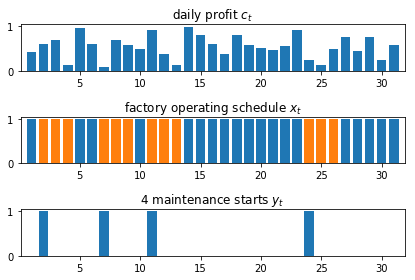

In [3]:
import pyomo.environ as pyo
import pyomo.gdp as gdp
import matplotlib.pyplot as plt

# pyomo model
m = pyo.ConcreteModel()

m.T = pyo.RangeSet(1, T)
m.Y = pyo.RangeSet(1, T-M+1)
m.S = pyo.RangeSet(0, M-1)

m.c = pyo.Param(m.T, initialize = c)
m.x = pyo.Var(m.T, domain=pyo.Binary)
m.y = pyo.Var(m.T, domain=pyo.Binary)

# objective
m.profit = pyo.Objective(expr = sum(m.c[t]*m.x[t] for t in m.T), sense=pyo.maximize)

# required number P of maintenance starts
m.sumy = pyo.Constraint(expr = sum(m.y[t] for t in m.Y) == P)

# no maintenance starts in the period of length M
m.sprd = pyo.Constraint(m.Y, rule = lambda m, t: sum(m.y[t+s] for s in m.S) <= 1)

# disjunctive constraints
m.disj = gdp.Disjunction(m.Y, m.S, rule = lambda m, t, s: [m.y[t]==0, sum(m.x[t+s] for s in m.S)==0])

# transformation and soluton
pyo.TransformationFactory('gdp.chull').apply_to(m)
pyo.SolverFactory('cbc').solve(m)

# plot
fig,ax = plt.subplots(3,1)

ax[0].bar(m.T, [m.c[t] for t in m.T])
ax[0].set_title('daily profit $c_t$')

ax[1].bar(m.T, [m.x[t]() for t in m.T])
ax[1].bar(m.T, [1-m.x[t]() for t in m.T])
ax[1].set_title('factory operating schedule $x_t$')

ax[2].bar(m.Y, [m.y[t]() for t in m.Y])
ax[2].set_title(str(P) + ' maintenance starts $y_t$')

for a in ax:
  a.set_xlim(0.1, T+0.9)

plt.tight_layout()

<!--NAVIGATION-->
< [Job Shop Scheduling](04.02-Job-Shop-Scheduling.ipynb) | [Contents](index.ipynb) | [Scheduling Multipurpose Batch Processes using State-Task Networks](04.04-Scheduling-Multipurpose-Batch-Processes-using-State-Task_Networks.ipynb) >

<a href="https://colab.research.google.com/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/04.03-Maintenance-Planning.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>
